In [1]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math

import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import linear_model
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()

dfo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfo)))

12813 races loaded!


In [3]:
category = 'R'
dfo = dfo.loc[dfo['race_type'].isin([category])]
print('{} {} races!'.format(len(dfo), category))

4259 R races!


In [4]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.describe()

,id,race_number,race_distance,num_runners
count,4259.000000,4259.000000,4259.000000,4259.000000
mean,7130.861705,4.632778,1662.498474,10.167645
std,3649.072073,2.516254,758.647782,3.158871
min,1610.000000,1.000000,402.000000,3.000000
25%,3793.500000,3.000000,1200.000000,8.000000
50%,7100.000000,4.000000,1400.000000,10.000000
75%,10390.500000,7.000000,1800.000000,12.000000
max,13488.000000,12.000000,6400.000000,24.000000


In [5]:
# bet size
balance = 1000
bet_chunk = balance * 0.01

In [6]:
def process_strategy(dfp, strategy, x):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in dfp.iterrows():
#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r['odds_win']]
        if not runners:
            continue
    
        # default 0 bets
        for runner in runners:
            runner['bet'] = 0
        
        runners, num_bets = strategy(runners, bet_chunk, x)
        if num_bets:
            bet_results(book, runners, race['num_runners'], bet_chunk, num_bets, race['race_type'])
            
    book_df = pd.DataFrame(book)
    return book_df

In [7]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets, race_type):
    """get results from bets"""
    win_diff = 0
    max_diff = 0
    prob2scales = []
    prob0scales = []
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['odds_scale'] - runner['probability'])
        max_diff = max(max_diff, diff)
        if runner['bet']:
            prob2scales.append(runner['probability'] / runner['odds_scale'])
            prob0scales.append(runner['probability'] - runner['odds_scale'])
        if int(runner['finishingPosition']) == 1:
            win_diff = diff
            if runner['bet'] > 0:
                # odds = runner['parimutuel']['returnWin'] if runner['parimutuel']['returnWin'] else runner['odds_win']
                odds = runner['odds_win']
                profit = runner['bet'] * odds - bet_chunk
                outcome = {
                    'success': 1,
                    'profit': profit,
                    'num_bets': num_bets,
                    'num_runners': num_runners,
                }
            break

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['prob2scale_avg'] = sum(prob2scales) / len(prob2scales)
    outcome['prob2scale'] = min(prob2scales)
    outcome['prob0scale'] = min(prob0scales)
    outcome['bet_chunk'] = bet_chunk
    outcome['race_type'] = race_type
    outcome['runners'] = runners
    book.append(outcome)

In [8]:
def bet_positive_dutch(runners, bet_chunk, x):
    """dutch betting on probability"""

    # sort runners from favourite to underdog
    runners.sort(key=lambda r: r['prediction'], reverse=True)
    
    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), 0, -1):

        # reset bets
        for runner in runners:
            runner['bet'] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
        # print('pool is {} from {} bets'.format(len(pool), num_bets))

        # all prediction values
        total_preds = sum([r['prediction'] for r in pool])

        # dutch for all in pool
        profits = []
        prob2scales = []
        for runner in pool:

            # scale bet according to prediction
            runner['bet'] = bet_chunk * runner['prediction'] / total_preds
            
            # need to check all as we scale to probs and not odds
            profits.append(runner['bet'] * runner['odds_win'] - bet_chunk)
            prob2scales.append(runner['probability'] / runner['odds_scale'])
            

        ###################################################################################        
        # MIN PROFIT
        ###################################################################################        
        min_profit_flag = False
        min_profit = min(profits)
        if min_profit > bet_chunk * x[0]:
            min_profit_flag = True

        ###################################################################################
        # MIN PROB 2 SCALE
        ###################################################################################
        min_probs2scale_flag = False
        min_probs2scale = min(prob2scales)
        if min_probs2scale >= x[1]:
            min_probs2scale_flag = True

        if min_profit_flag and min_probs2scale_flag:
            #print('breaking: {} {} {} {}'.format(min_profit_flag, avg_profit_flag, num_bets_flag, min_probs2scale_flag))
            break
    else:
#         print('no profit determined')
        return [], 0

    # put bets from pool into runners
    for p in pool:
        for r in runners:
            if r['runnerNumber'] == p['runnerNumber']:
                r['bet'] = p['bet']
                break

    return runners, num_bets

In [32]:
def f(x):
    book_df = process_strategy(dfo, bet_positive_dutch, x)
    #print(book_df)
    if not len(book_df):
        return 0
    profit = book_df.profit.sum()
    #mul = len(book_df) / len(dfo)
    mul = len(book_df) ** 2 / float(len(dfo) ** 2)
    return profit * mul * -1

# x0 => num bets
# x1 => min profit
# x2 => min probs2scale
x, *grid = sp.optimize.brute(f, np.s_[0:2:10j, 1.10:1.30:10j], full_output=True)
# x = sp.optimize.fmin_l_bfgs_b(f, [2.34375000e-05, 1.16268092e+00], bounds=((1, 4), (1, 1.3)))
print('x: {}'.format(x))
print('grid: {}'.format(grid))

x: [ 0.88576389  1.22591146]
grid: [-0.62984750474330498, array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.22222222,  0.22222222,  0.22222222,  0.22222222,  0.22222222,
          0.22222222,  0.22222222,  0.22222222,  0.22222222,  0.22222222],
        [ 0.44444444,  0.44444444,  0.44444444,  0.44444444,  0.44444444,
          0.44444444,  0.44444444,  0.44444444,  0.44444444,  0.44444444],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
          0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667],
        [ 0.88888889,  0.88888889,  0.88888889,  0.88888889,  0.88888889,
          0.88888889,  0.88888889,  0.88888889,  0.88888889,  0.88888889],
        [ 1.11111111,  1.11111111,  1.11111111,  1.11111111,  1.11111111,
          1.11111111,  1.11111111,  1.11111111,  1.11111111,  1.11111111],
        [ 1.33333333,  1.33333333,  1.33333333, 

In [33]:
print('x: {}'.format(x))
df = process_strategy(dfo, bet_positive_dutch, x)
print('{:.0f}% {} races out of {}'.format(len(df) / len(dfo) * 100, len(df), len(dfo)))

x: [ 0.88576389  1.22591146]
5% 208 races out of 4259


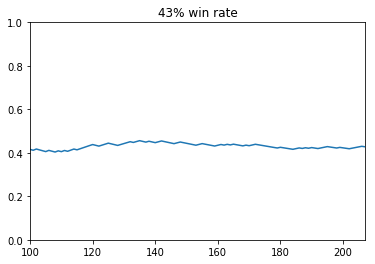

In [34]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

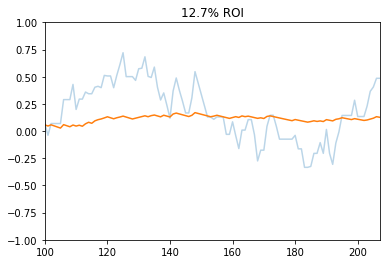

In [35]:
# ROI
roi = df.profit.rolling(20).sum() / df.bet_chunk.rolling(20).sum()
roi.plot(xlim=(100), ylim=(-1, 1), alpha=0.3)
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.plot(xlim=(100), ylim=(-1, 1), title=roi_title)

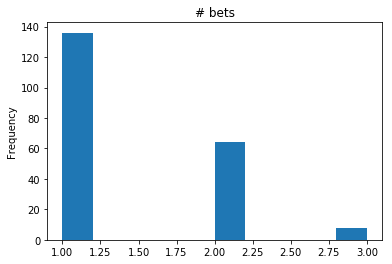

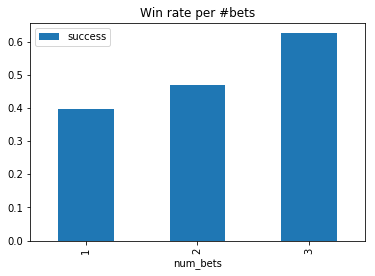

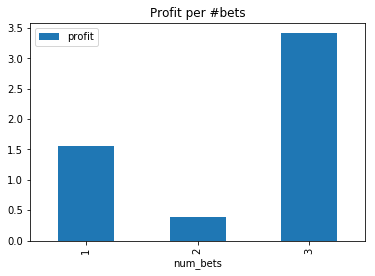

In [36]:
# profit per num bets 
df.num_bets.plot(kind='hist', title='# bets')
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

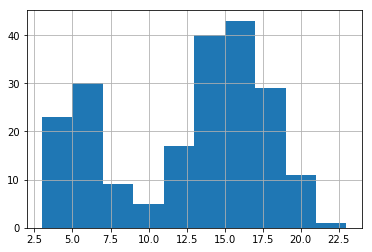

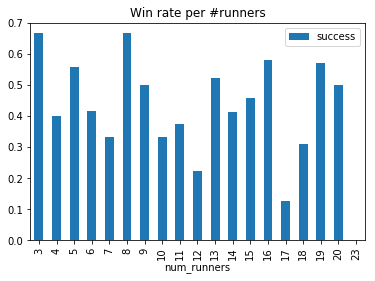

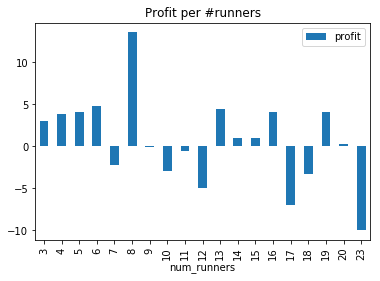

In [37]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

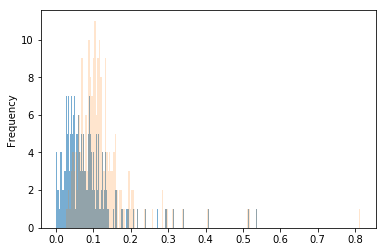

In [38]:
# max diff
df.win_diff.plot(kind='hist', bins=200, alpha=0.6)
df.max_diff.plot(kind='hist', bins=200, alpha=0.2)

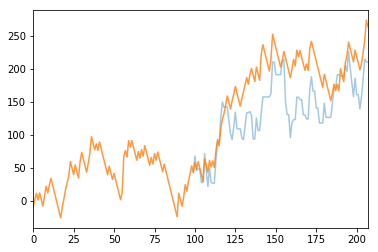

In [39]:
# df.profit.plot(kind='hist', bins=50, xlim=(-5), ylim=(0, 140))
df.profit.rolling(100).sum().plot(alpha=0.4)
df.profit.cumsum().plot(alpha=0.8)

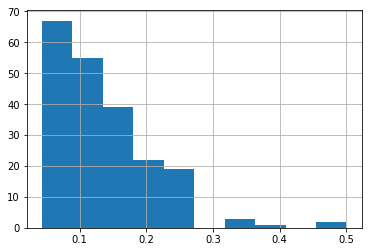

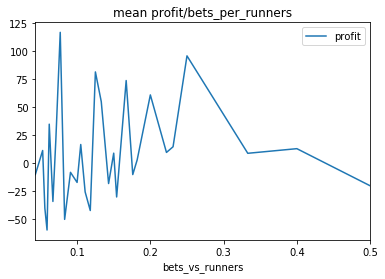

In [40]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

In [41]:
# # pred vs scale
# df['prob_vs_scale'] = df.pr / df.num_runners
# df['bets_vs_runners'].hist(bins=10)
# groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
# groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

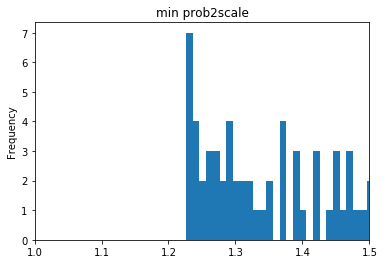

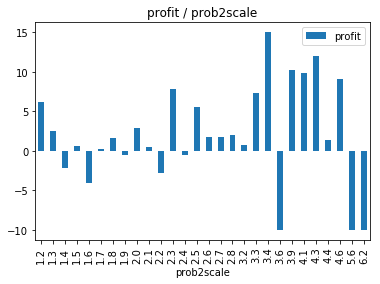

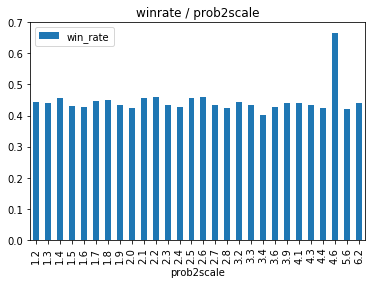

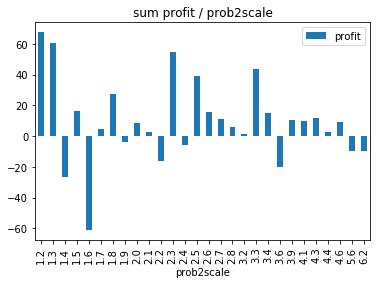

In [42]:
df.prob2scale.plot(kind='hist', bins=500, title='min prob2scale', xlim=(1, 1.5))
groups = df.groupby(df['prob2scale'].apply(lambda x: round(x, 1))).mean()
groups.plot(kind='bar', y='profit', title='profit / prob2scale')
groups.plot(kind='bar', y='win_rate', title='winrate / prob2scale')

groups_sum = df.groupby(df['prob2scale'].apply(lambda x: round(x, 1))).sum()
groups_sum.plot(kind='bar', y='profit', title='sum profit / prob2scale')

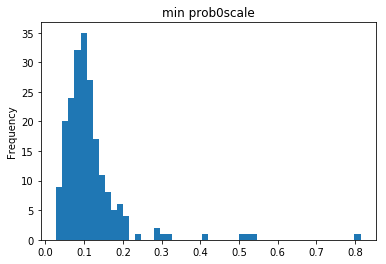

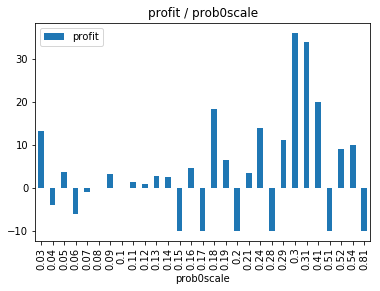

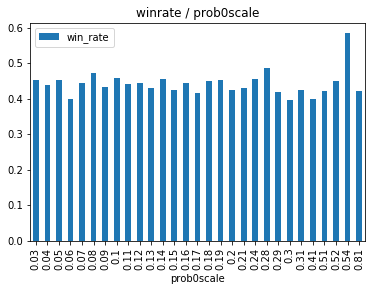

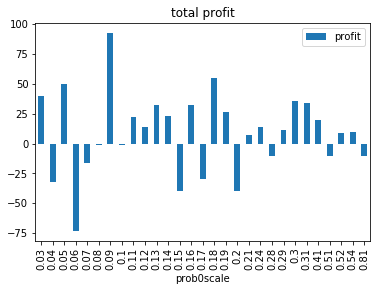

In [43]:
df.prob0scale.plot(kind='hist', bins=50, title='min prob0scale')
groups = df.groupby(df['prob0scale'].apply(lambda x: round(x, 2))).mean()
groups.plot(kind='bar', y='profit', title='profit / prob0scale')
groups.plot(kind='bar', y='win_rate', title='winrate / prob0scale')

groups_sum = df.groupby(df['prob0scale'].apply(lambda x: round(x, 2))).sum()
groups_sum.plot(kind='bar', y='profit', title='total profit')

In [44]:
df.bet.plot(kind='bar', title='Bet size')

AttributeError: 'DataFrame' object has no attribute 'bet'